## Exploration

train.csv shape is  (139753, 9)
test.csv shape is  (17470, 2)

        Id   ProductId          UserId  HelpfulnessNumerator  \
0   195370  1890228583  A3VLX5Z090RQ0V                     1   
1  1632470  B00BEIYSL4   AUDXDMFM49NGY                     0   
2     9771  0767809335  A3LFIA97BUU5IE                     3   
3   218855  6300215792  A1QZM75342ZQVQ                     1   
4   936225  B000B5XOZW   ANM2SCEUL3WL1                     1   

   HelpfulnessDenominator        Time  \
0                       2  1030838400   
1                       1  1405036800   
2                      36   983750400   
3                       1  1394841600   
4                       1  1163721600   

                                             Summary  \
0                        An Unexplained Anime Review   
1                                         not great.   
2                    Technical problem with this DVD   
3                          Heeeeyyyyy LAAAAADEEE!!!!   
4  Herzog the Great Trave

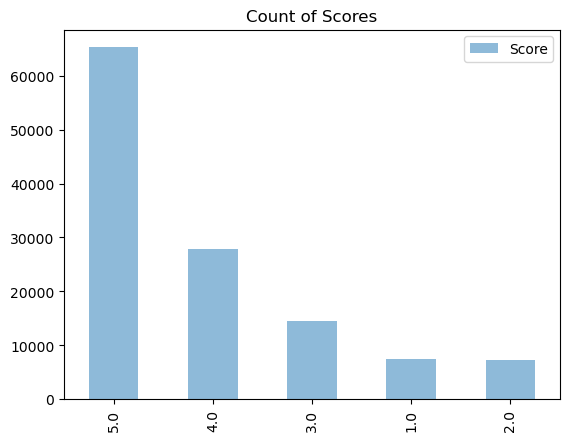

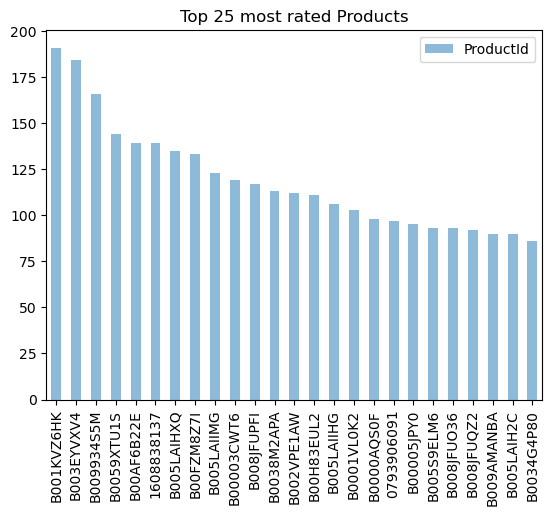

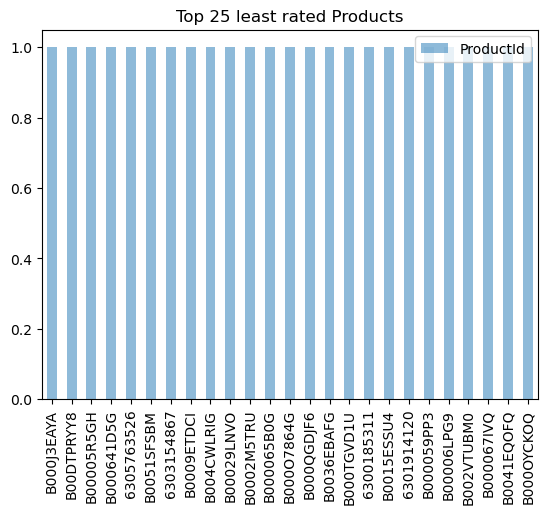

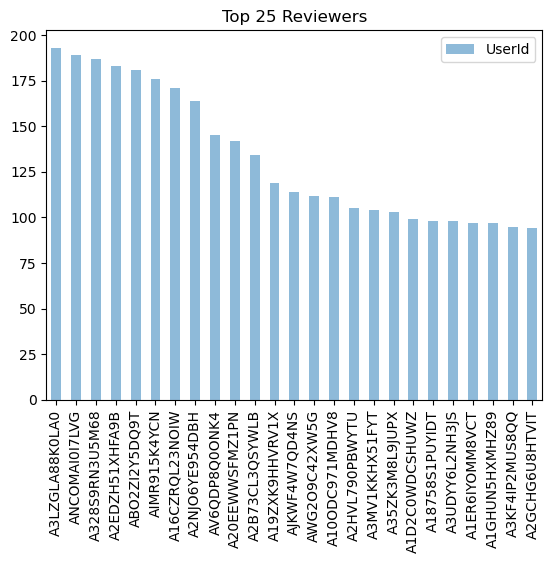

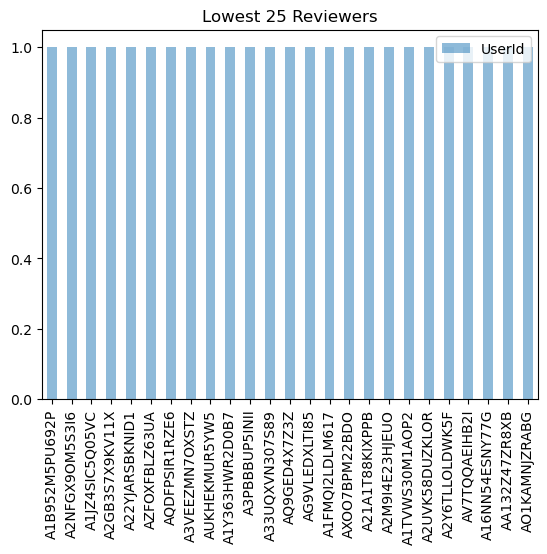

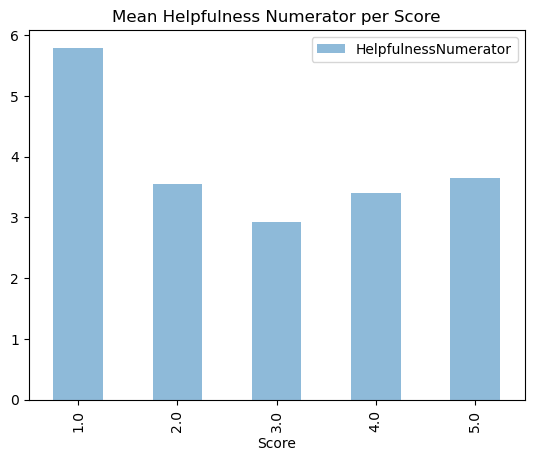

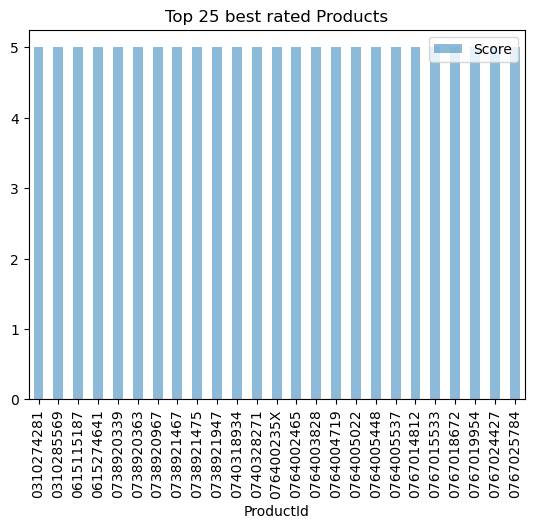

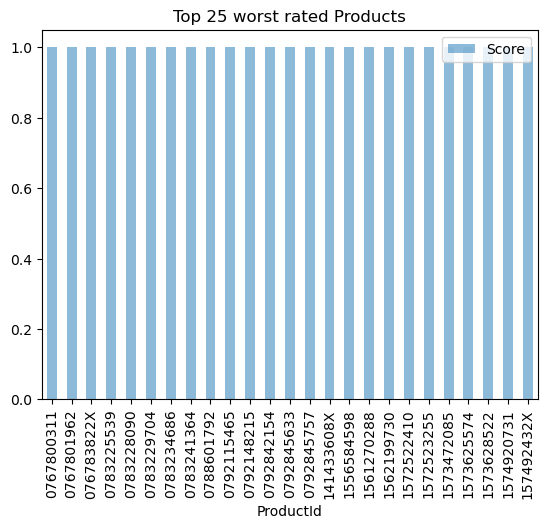

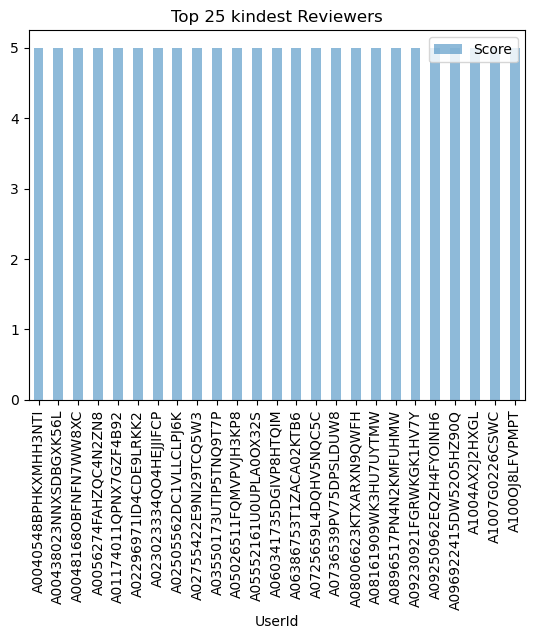

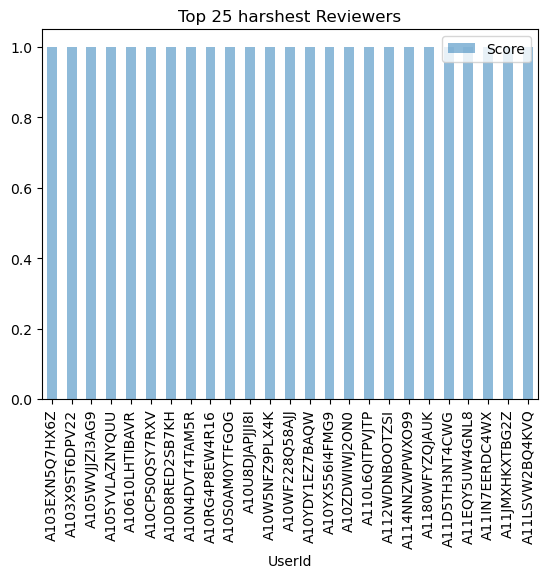

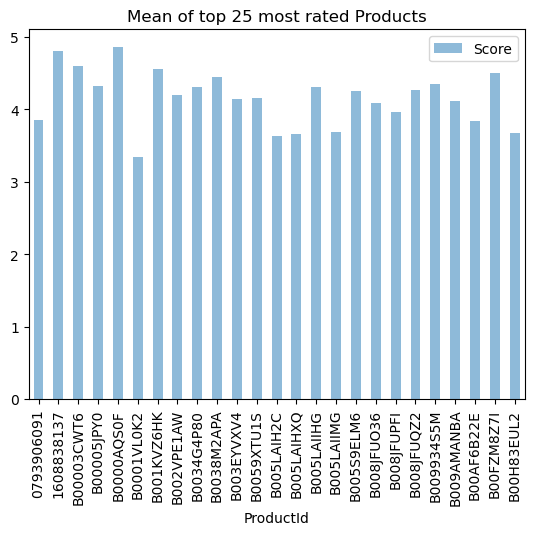

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

trainingSet = pd.read_csv("./data/train.csv")
testingSet = pd.read_csv("./data/test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print()

print(trainingSet.head())
print()
print(testingSet.head())

print()

print(trainingSet.describe())

trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.title("Count of Scores")
plt.show()

trainingSet['ProductId'].value_counts().nlargest(25).plot(kind='bar', legend=True, alpha=.5)
plt.title("Top 25 most rated Products")
plt.show()

trainingSet['ProductId'].value_counts().nsmallest(25).plot(kind='bar', legend=True, alpha=.5)
plt.title("Top 25 least rated Products")
plt.show()

trainingSet['UserId'].value_counts().nlargest(25).plot(kind='bar', legend=True, alpha=.5)
plt.title("Top 25 Reviewers")
plt.show()

trainingSet['UserId'].value_counts().nsmallest(25).plot(kind='bar', legend=True, alpha=.5)
plt.title("Lowest 25 Reviewers")
plt.show()

trainingSet[['Score', 'HelpfulnessNumerator']].groupby('Score').mean().plot(kind='bar', legend=True, alpha=.5)
plt.title("Mean Helpfulness Numerator per Score")
plt.show()

trainingSet[['Score', 'ProductId']].groupby('ProductId').mean().nlargest(25, 'Score').plot(kind='bar', legend=True, alpha=.5)
plt.title("Top 25 best rated Products")
plt.show()

trainingSet[['Score', 'ProductId']].groupby('ProductId').mean().nsmallest(25, 'Score').plot(kind='bar', legend=True, alpha=.5)
plt.title("Top 25 worst rated Products")
plt.show()

trainingSet[['Score', 'UserId']].groupby('UserId').mean().nlargest(25, 'Score').plot(kind='bar', legend=True, alpha=.5)
plt.title("Top 25 kindest Reviewers")
plt.show()

trainingSet[['Score', 'UserId']].groupby('UserId').mean().nsmallest(25, 'Score').plot(kind='bar', legend=True, alpha=.5)
plt.title("Top 25 harshest Reviewers")
plt.show()

trainingSet[trainingSet['ProductId'].isin(trainingSet['ProductId'].value_counts().nlargest(25).index.tolist())][['Score', 'ProductId']].groupby('ProductId').mean().plot(kind='bar', legend=True, alpha=.5)
plt.title("Mean of top 25 most rated Products")
plt.show()

## Feature Extraction

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob

def process(df, text_vectorizer=None, summary_vectorizer=None):
    """
    Process the dataframe to extract features and transform text data.

    :param df: Pandas DataFrame containing the data.
    :param text_vectorizer: Fitted TfidfVectorizer for the 'Text' column.
    :param summary_vectorizer: Fitted TfidfVectorizer for the 'Summary' column.
    :return: DataFrame with new features and transformed text.
    """
    
    df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
    df['Helpfulness'] = df['Helpfulness'].fillna(0)

    
    df['ReviewLength'] = df.apply(lambda row: len(row['Text'].split()) if pd.notnull(row['Text']) else 0, axis=1)

    
    df['SummaryLength'] = df.apply(lambda row: len(row['Summary'].split()) if pd.notnull(row['Summary']) else 0, axis=1)

    
    df['ReviewYear'] = pd.to_datetime(df['Time'], unit='s').dt.year

    
    df['ReviewSentiment'] = df['Text'].apply(lambda x: TextBlob(x).sentiment.polarity if pd.notnull(x) else 0)
    df['SummarySentiment'] = df['Summary'].apply(lambda x: TextBlob(x).sentiment.polarity if pd.notnull(x) else 0)

    
    if text_vectorizer and summary_vectorizer:
        text_features = text_vectorizer.transform(df['Text'].astype('U')).toarray()
        summary_features = summary_vectorizer.transform(df['Summary'].astype('U')).toarray()
    else:
        raise ValueError("The text_vectorizer and summary_vectorizer must be fitted on the training data and provided to the function.")

    
    text_df = pd.DataFrame(text_features, columns=["text_tfidf_" + str(i) for i in range(text_features.shape[1])])
    summary_df = pd.DataFrame(summary_features, columns=["summary_tfidf_" + str(i) for i in range(summary_features.shape[1])])

    
    df = pd.concat([df, text_df, summary_df], axis=1)

    return df



## Creating your model

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/hasanmustafabayli/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


/Users/hasanmustafabayli/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/hasanmustafabayli/anaconda3/lib/python3.11/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


RMSE for XGBoost: 0.9633241321487368
Accuracy for XGBoost: 0.4432632233162147


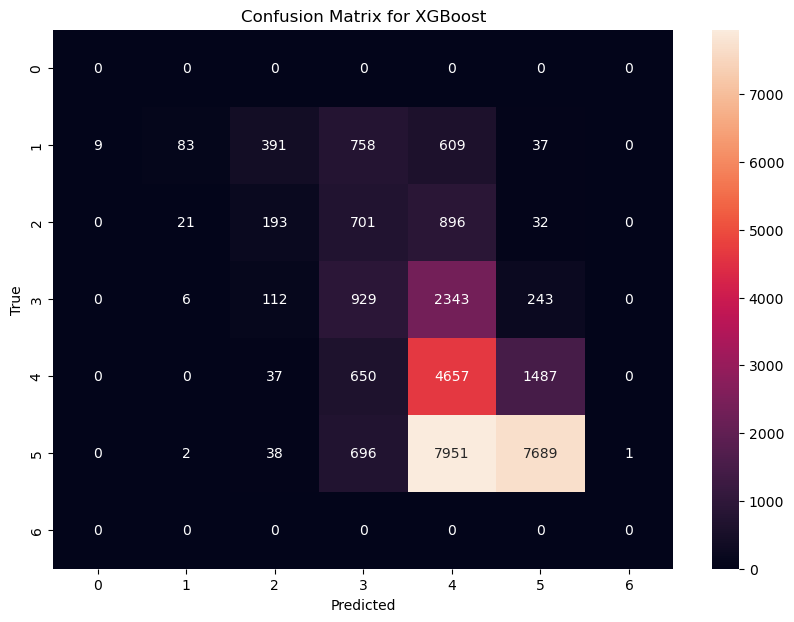

In [2]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import os
from xgboost import XGBRegressor
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk


nltk.download('vader_lexicon')


sid = SentimentIntensityAnalyzer()


train_df = pd.read_csv("./data/train.csv")


train_df.dropna(subset=['Score'], inplace=True)


train_df['ProcessedText'] = train_df['Text'].str.lower()
train_df['ProcessedText'].fillna('', inplace=True) 


train_df['SentimentScore'] = train_df['ProcessedText'].apply(lambda text: sid.polarity_scores(text)['compound'])


tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), stop_words='english', max_features=10000)
tfidf_features = tfidf_vectorizer.fit_transform(train_df['ProcessedText'])


n_components = 150
svd = TruncatedSVD(n_components=n_components, random_state=42)
reduced_features = svd.fit_transform(tfidf_features)


import scipy.sparse as sp
sentiment_scores = sp.csr_matrix(train_df['SentimentScore'].values.reshape(-1, 1)) 
combined_features = sp.hstack([reduced_features, sentiment_scores])


X_train, X_test, y_train, y_test = train_test_split(
    combined_features,
    train_df['Score'],
    test_size=0.25,
    random_state=42
)


param_grid = {
    'n_estimators': [100, 200], 
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 6],
    'subsample': [0.8],
    'colsample_bytree': [0.8]
}


xgb_model = XGBRegressor(random_state=42)


random_search_xgb = RandomizedSearchCV(
    xgb_model,
    param_distributions=param_grid,
    n_iter=10, 
    scoring='neg_root_mean_squared_error',
    cv=3, 
    verbose=1,
    random_state=42,
    n_jobs=-1 
)

sample_size = 10000 
small_X_train = X_train[:sample_size]
small_y_train = y_train[:sample_size]

random_search_xgb.fit(small_X_train, small_y_train)


best_xgb_model = random_search_xgb.best_estimator_


best_xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    early_stopping_rounds=10,
    verbose=False
)


y_pred_xgb = best_xgb_model.predict(X_test)


rmse_xgb = mean_squared_error(y_test, y_pred_xgb, squared=False)
print(f'RMSE for XGBoost: {rmse_xgb}')


accuracy_xgb = accuracy_score(y_test, y_pred_xgb.round())
print(f'Accuracy for XGBoost: {accuracy_xgb}')


output_dir = "./data"
xgb_model_filename = os.path.join(output_dir, 'xgb_model.pkl')
with open(xgb_model_filename, 'wb') as file:
    pickle.dump(best_xgb_model, file)

plt.figure(figsize=(10, 7))

cm = sns.heatmap(confusion_matrix(y_test, y_pred_xgb.round()), annot=True, fmt='d')
plt.title('Confusion Matrix for XGBoost')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


tfidf_filename = os.path


## Create the Kaggle submission

In [13]:
import pandas as pd
import pickle
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
from xgboost import XGBRegressor


output_dir = "./data"
xgb_model_filename = os.path.join(output_dir, 'xgb_model.pkl')

with open(xgb_model_filename, 'rb') as file:
    best_xgb_model = pickle.load(file)


test_df = pd.read_csv("./data/X_test.csv")


nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()


test_df['ProcessedText'] = test_df['Text'].str.lower()
test_df['ProcessedText'].fillna('', inplace=True) 


test_df['SentimentScore'] = test_df['ProcessedText'].apply(lambda text: sid.polarity_scores(text)['compound'])


tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), stop_words='english', max_features=10000)
tfidf_features = tfidf_vectorizer.fit_transform(test_df['ProcessedText'])


n_components = 150
svd = TruncatedSVD(n_components=n_components, random_state=42)
reduced_features = svd.fit_transform(tfidf_features)


import scipy.sparse as sp
sentiment_scores = sp.csr_matrix(test_df['SentimentScore'].values.reshape(-1, 1))  
combined_features = sp.hstack([reduced_features, sentiment_scores])


test_predictions = best_xgb_model.predict(combined_features)


test_predictions_rounded = test_predictions.round()


submission_df = pd.DataFrame({
    'Id': test_df['Id'],
    'Score': test_predictions_rounded
})


submission_filename = os.path.join(output_dir, 'submission.csv')
submission_df.to_csv(submission_filename, index=False)

print(f'Submission file saved to {submission_filename}')


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/hasanmustafabayli/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Submission file saved to ./data/submission.csv


In [ ]:
pip show scikit-learn

Name: scikit-learn
Version: 1.3.0
Summary: A set of python modules for machine learning and data mining
Home-page: http://scikit-learn.org
Author: 
Author-email: 
License: new BSD
Location: /Users/hasanmustafabayli/anaconda3/lib/python3.11/site-packages
Requires: joblib, numpy, scipy, threadpoolctl
Required-by: imbalanced-learn
Note: you may need to restart the kernel to use updated packages.


Now you can upload the `submission.csv` to kaggle